[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtrando e ajustando mensagens

## Revisão

Agora, temos um entendimento mais profundo de algumas coisas:

* Como personalizar o esquema de estado do grafo
* Como definir redutores de estado personalizados
* Como usar múltiplos esquemas de estado do grafo

## Objetivos

Agora, podemos começar a usar esses conceitos com modelos no LangGraph!

Nas próximas sessões, construiremos um chatbot com memória de longo prazo.

Como nosso chatbot usará mensagens, vamos primeiro falar um pouco mais sobre formas avançadas de trabalhar com mensagens no estado do grafo.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [3]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Mensagens como estado

Primeiro, vamos definir algumas mensagens.

In [9]:

from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

messages = [
    SystemMessage("Responda sempre em português do Brasil."),
    AIMessage(f"So you said you were researching ocean mammals?", name="Bot"),
    HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance")
]

for m in messages:
    m.pretty_print()

================================ System Message ================================

Responda sempre em português do Brasil.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Lembre-se que podemos passá-las para um modelo de chat.

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(messages)

AIMessage(content='Além das baleias, há muitos outros mamíferos marinhos interessantes para aprender. Aqui estão alguns deles:\n\n1. **Golfinhos**: Conhecidos por sua inteligência e comportamento social, os golfinhos são muito populares e existem várias espécies, como o golfinho-nariz-de-garrafa.\n\n2. **Focas**: Existem várias espécies de focas, que são adaptadas a ambientes aquáticos. As focas comuns e as focas-leão são exemplos bem conhecidos.\n\n3. **Leões-marinhos**: Esses mamíferos são conhecidos por suas longas nadadeiras e comportamento social. Eles costumam ser vistos em colônias.\n\n4. **Manatins**: Também conhecidos como vacas-marinha, esses herbívoros são encontrados em águas rasas e são conhecidos por sua natureza gentil.\n\n5. **Lamantins**: Semelhantes aos manatins, mas geralmente maiores, os lamantins também se alimentam de plantas aquáticas e são encontrados em áreas costeiras.\n\n6. **Orcas**: Também conhecidas como baleias assassinas, as orcas são na verdade golfinho

Podemos executar nosso modelo de chat em um grafo simples com `MessagesState`.

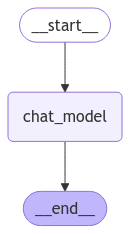

In [11]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ System Message ================================

Responda sempre em português do Brasil.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Além das baleias, existem diversos outros mamíferos marinhos interessantes que você pode estudar. Aqui estão alguns deles:

1. **Golfinhos**: Conhecidos por sua inteligência e comportamento social, os golfinhos são fascinantes e possuem diversas espécies, como o golfinho-nariz-de-garrafa.

2. **Focas**: Existem várias espécies de focas, como a foca-comum e a foca-leopardo. Elas são adaptadas a ambientes frios e são excelentes nadadoras.

3. **Leões-marinhos**: Semelhantes às focas, mas com ore

## Redutor

Um desafio prático ao trabalhar com mensagens é gerenciar conversas longas.

Conversas longas resultam em alto uso de tokens e latência se não formos cuidadosos, porque passamos uma lista crescente de mensagens para o modelo.

Temos algumas maneiras de lidar com isso.

Primeiro, lembre-se do truque que vimos usando `RemoveMessage` e o redutor `add_messages`.

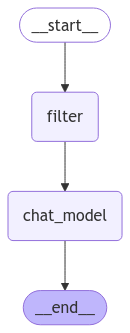

In [16]:
from langchain_core.messages import RemoveMessage


# Nós
def filter_messages(state: MessagesState):
    # Excluir todas as mensagens, exceto as 2 mais recentes
    delete_messages = [
        RemoveMessage(id=m.id) for m in state["messages"][:-2]
        if type(m) is not SystemMessage
    ]
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}


# Construir grafo
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# Lista de mensagens com um preâmbulo
messages = [
    SystemMessage("Responda sempre em português do Brasil."),
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"),
]

# Invocar
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ System Message ================================

Responda sempre em português do Brasil.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Além das baleias, existem vários outros mamíferos marinhos interessantes que você pode aprender sobre. Aqui estão alguns deles:

1. **Golfinhos**: Conhecidos por sua inteligência e comportamento social, os golfinhos são frequentemente vistos em grupos e possuem uma variedade de vocalizações.

2. **Focas**: Existem várias espécies de focas, como a foca-comum e a foca-leopardo. Elas são adaptadas para a vida no mar, mas também passam tempo em terra.

3. **Leões-marinhos**: Semelhantes às focas, 

## Filtrando mensagens

Se você não precisa ou não quer modificar o estado do grafo, você pode simplesmente filtrar as mensagens que passa para o modelo de chat.

Por exemplo, basta passar uma lista filtrada: `llm.invoke(messages[-1:])` para o modelo.

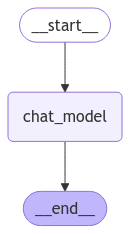

In [18]:
# Nó
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Construir grafo
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

Vamos pegar nossa lista existente de mensagens, anexar a resposta do LLM acima e anexar uma pergunta de acompanhamento.

In [20]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [21]:
for m in messages:
    m.pretty_print()

================================ System Message ================================

Responda sempre em português do Brasil.
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Além das baleias, existem vários outros mamíferos marinhos interessantes que você pode aprender sobre. Aqui estão alguns deles:

1. **Golfinhos**: Conhecidos por sua inteligência e comportamento social, os golfinhos são frequentemente vistos em grupos e possuem uma variedade de vocalizações.

2. **Focas

In [22]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ System Message ================================

Responda sempre em português do Brasil.
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Além das baleias, existem vários outros mamíferos marinhos interessantes que você pode aprender sobre. Aqui estão alguns deles:

1. **Golfinhos**: Conhecidos por sua inteligência e comportamento social, os golfinhos são frequentemente vistos em grupos e possuem uma variedade de vocalizações.

2. **Focas

O estado tem todas as mensagens.

Mas, vamos olhar o rastreamento do LangSmith para ver que a invocação do modelo usa apenas a última mensagem:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Ajustar mensagens

Outra abordagem é [ajustar as mensagens](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), com base em um número definido de tokens.

Isso restringe o histórico de mensagens a um número específico de tokens.

Enquanto a filtragem retorna apenas um subconjunto post-hoc das mensagens entre agentes, o ajuste restringe o número de tokens que um modelo de chat pode usar para responder.

Veja o `trim_messages` abaixo.

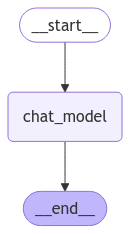

In [23]:
from langchain_core.messages import trim_messages


# Nó
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o-mini"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Construir grafo
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [25]:
# Example of trimming messages
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o-mini"),
    allow_partial=False
)

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [26]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Vamos olhar o rastreamento do LangSmith para ver a invocação do modelo:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r